In [297]:
!kaggle datasets download -d karkavelrajaj/amazon-sales-dataset
!pip install -U sentence-transformers faiss-cpu

Dataset URL: https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset
License(s): CC-BY-NC-SA-4.0
amazon-sales-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [298]:
import numpy as np
import pandas as pd
import zipfile
import os
from sentence_transformers import SentenceTransformer
from typing import List, Tuple
import faiss
import warnings
warnings.filterwarnings("ignore")

In [299]:
def unzipper(data_path:str):
  with zipfile.ZipFile(data_path) as file:
    file.extractall(os.getcwd())

unzipper("/content/amazon-sales-dataset.zip")

In [300]:
df = pd.read_csv("/content/amazon.csv")
df.head(3)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [302]:
df.duplicated(subset=["product_name"]).sum()

128

In [303]:
df.drop_duplicates(subset="product_name", inplace=True)

In [304]:
df = df[["product_name", "about_product"]]
df["content"] = df["product_name"] + " " + df["about_product"]

df.head(3)

,product_name,about_product,content
0,Wayona Nylon Braided USB to Lightning Fast Cha...,High Compatibility : Compatible With iPhone 12...,Wayona Nylon Braided USB to Lightning Fast Cha...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,"Compatible with all Type C enabled devices, be...",Ambrane Unbreakable 60W / 3A Fast Charging 1.5...
2,Sounce Fast Phone Charging Cable & Data Sync U...,【 Fast Charger& Data Sync】-With built-in safet...,Sounce Fast Phone Charging Cable & Data Sync U...


In [305]:
def text_vectorizer(
    row:str,
    model_name:str="all-MiniLM-L6-v2",
    print_content:bool=False
  )->Tuple[str, np.array]:
  model = SentenceTransformer(model_name)
  embeddings = model.encode(row)
  if print_content==True:
    return embeddings, row
  else:
    return embeddings

In [306]:
model = SentenceTransformer("all-MiniLM-L6-v2")
df["vectors"] = df["content"].apply(lambda x: model.encode(x))

#### Cosine Similarity
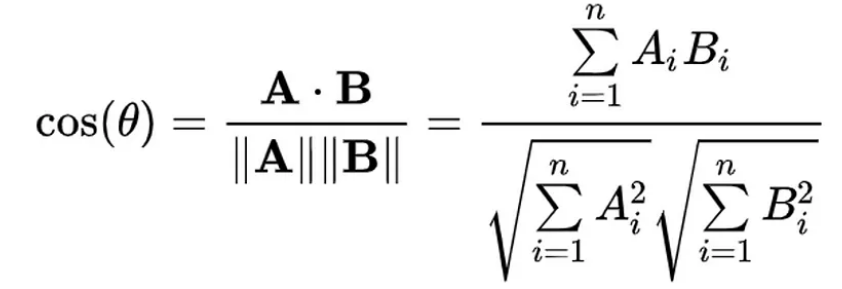

In [307]:
def cosine_similarity(A: np.array, B: np.array):
  similarity = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
  return similarity

In [308]:
# Quick Check
A = np.array([0.3, 4.6, 0.2, 0.2])
B = np.array([0.6, 0.2, 0.7, 0.1])

cosine_similarity(A, B)

0.28757681050621636

In [309]:
text_vectorizer(df["content"][100], print_content=True)

(array([-6.56458661e-02, -3.55995470e-03,  3.24659087e-02, -1.89342909e-02,
         9.10668597e-02,  7.22628012e-02,  8.46147314e-02,  6.10961393e-02,
         1.56087773e-02,  3.66877913e-02,  3.06340531e-02,  4.73225638e-02,
        -2.37756060e-03, -3.57887521e-03,  5.86125851e-02, -7.14294389e-02,
        -3.31922024e-02, -9.26762968e-02,  7.48173613e-03, -7.40851602e-03,
         2.56969817e-02,  1.30972816e-02,  4.68675047e-02, -9.47100949e-03,
        -1.01540610e-01, -1.52057139e-02, -1.06275280e-03,  1.02319876e-02,
         8.21127649e-03, -3.20914723e-02, -5.18459594e-04, -1.08917281e-02,
        -1.68213323e-02,  7.14273676e-02, -5.11529595e-02, -7.41993189e-02,
         1.91855710e-02,  2.65987329e-02, -1.10510319e-01,  4.29097787e-02,
        -1.84638444e-02, -5.32994792e-02, -2.74073053e-02, -8.22260138e-03,
         4.40068617e-02,  4.28791828e-02, -1.59176849e-02, -2.86437292e-02,
        -1.62171628e-02,  7.30115771e-02,  2.53202417e-03,  6.61505833e-02,
         4.9

In [310]:
click_vector = text_vectorizer(df["content"][100])
similarity_score = np.array([cosine_similarity(click_vector, embed) for embed in df["vectors"]])
index = np.argsort(-similarity_score)[:5]
index

array([100, 271, 243,  79, 121])

In [311]:
recommended_products = df.iloc[index]["product_name"]

for idx, product in enumerate(recommended_products, 1):
  print(f"{idx}. {product}")

1. Dealfreez Case Compatible with Fire TV Stick 3rd Gen 2021 Full Wrap Silicone Remote Cover Anti-Lost with Loop (D-Black)
2. Dealfreez Case Compatible for Fire TV Stick 4K All Alexa Voice Remote Shockproof Silicone Anti-Lost Cover with Loop (C-Black)
3. Smashtronics® - Case for Firetv Remote, Fire Stick Remote Cover Case, Silicone Cover for TV Firestick 4K/TV 2nd Gen(3rd Gen) Remote Control - Light Weight/Anti Slip/Shockproof (Black)
4. Firestick Remote
5. Remote Control Compatible for Amazon Fire Tv Stick Remote Control [ 3rd Gen ](Not Compatible for Fire TV Edition Smart TV) from basesailor


In [312]:
def show_recommandation(click_id:int, n_items:int=5)->str:
  user_click = df["content"][click_id]
  click_vector = model.encode(user_click)
  similarity_score = np.array([cosine_similarity(click_vector, embed) for embed in df["vectors"]])
  index = np.argsort(-similarity_score)[1:n_items+1]
  recommended_products = df.iloc[index]["product_name"]

  print(f"USER CLICKED PRODUCT: \n{user_click}\n")
  print(f"RECOMMANDATIONS:")
  for product in recommended_products:
    print("-" * 100)
    print(product)

In [321]:
show_recommandation(15)

USER CLICKED PRODUCT: 
MI Braided USB Type-C Cable for Charging Adapter (Red) 1M Long Cable. Usb 2.0 (Type A)|Toughened Joints|Strong And Sturdy|Country Of Origin: China|6 Months Warranty

RECOMMANDATIONS:
----------------------------------------------------------------------------------------------------
MI Braided USB Type-C Cable for Charging Adapter (Red)
----------------------------------------------------------------------------------------------------
Duracell Type-C To Micro 1.2M braided Sync & Charge Cable, USB C to Micro Fast Charge Compatible for fast data transmission (Black)
----------------------------------------------------------------------------------------------------
MI Usb Type-C Cable Smartphone (Black)
----------------------------------------------------------------------------------------------------
MI 2-in-1 USB Type C Cable (Micro USB to Type C) 30cm for Smartphone, Headphone, Laptop (White)
--------------------------------------------------------------------

## Use of Vector Database (FAISS)

#### Euclidean Distance
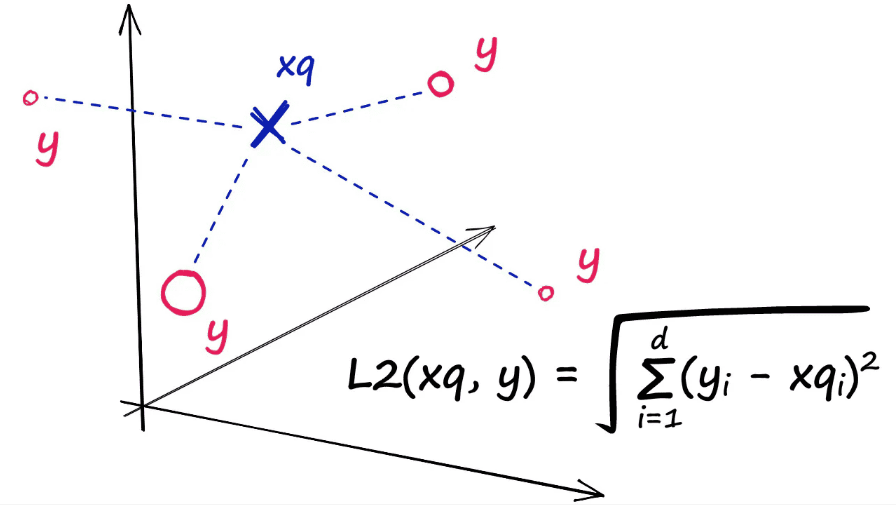

In [314]:
def euclidean_distance(A:np.array, B:np.array): # A & B are N-dimentional vectors
  distance = np.linalg.norm(A - B)
  return distance

In [315]:
raw_texts = df["content"].tolist()
embeddings = text_vectorizer(raw_texts)

In [316]:
embeddings

array([[-0.13701259,  0.01449694, -0.00809354, ..., -0.02577125,
         0.12942351,  0.06100712],
       [-0.17412107,  0.06250349,  0.02728059, ..., -0.05485894,
         0.06120034,  0.00982524],
       [-0.12450498,  0.06339029,  0.00199224, ..., -0.0562752 ,
         0.07707054,  0.07324154],
       ...,
       [-0.01172855,  0.03472459,  0.00403913, ...,  0.01503799,
        -0.07227145, -0.02417822],
       [-0.00242575,  0.06012955,  0.04569469, ...,  0.02639063,
        -0.04682443,  0.05711881],
       [-0.0790276 ,  0.06543758, -0.0870228 , ..., -0.02274159,
        -0.02947701, -0.00135182]], dtype=float32)

In [317]:
def show_recommandation(click_id:int, n_items:int=5)->str:
  user_click = df["content"][click_id]
  click_vector = model.encode(user_click).reshape(1, -1)
  index = faiss.IndexFlatL2(embeddings.shape[1])
  index.add(embeddings)
  distance, idx = index.search(click_vector, n_items)
  recommended_products = df.iloc[idx[0]]["product_name"]

  print(f"USER CLICKED PRODUCT: \n{user_click}\n")
  print(f"RECOMMANDATIONS:")
  for product in recommended_products:
    print("-" * 100)
    print(f"{product}")

In [318]:
show_recommandation(25)

USER CLICKED PRODUCT: 
Tizum High Speed HDMI Cable with Ethernet | Supports 3D 4K | for All HDMI Devices Laptop Computer Gaming Console TV Set Top Box (1.5 Meter/ 5 Feet) Latest Standard HDMI A Male to A Male Cable: Supports Ethernet, 3D, 4K video and Audio Return Channel (ARC)|Connects Blu-ray players, Fire TV, Apple TV, PS4, PS3, Xbox One, Xbox 360, Computers, DVD Players, Set Top Box, Dish TV Box, and other HDMI-enabLED devices to TVs, displays, A/V receivers and more.Suitable For Mp3, Gaming Device, Mobile, Tablet, Laptop|Cable allows you to share an Internet connection among multiple devices without the need for a separate Ethernet cable|Meets HDMI 1.4 Standards (4K Video at 24 Hz, 2160p, 48 bit/px color depth) that supports bandwidth up to 10.2Gbps and backwards compatible with earlier versions|✔ Gold Plate HDMI Cable of Length: 5 Feet/ 1.8 Meters

RECOMMANDATIONS:
----------------------------------------------------------------------------------------------------
Tizum High Spee